# Bean Classification Project Proposal 

In [1]:
#run this cell before continuing

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 16)
library(readxl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Introduction

This dataset is based on 13611 images of 7 types of individual dry beans with similar features. Each image was analyzed for 16 features of the bean (4 "shape factors", 12 structural/geometric features). 

The question we will be answering is whether we can determine the bean type in an image based on the measured physical measurements of the bean. We will be using K-nearest neighbors classification to predict "Class" using the predictors "Area", and "roundness". 

# Preliminary exploratory data analysis

In [2]:
beanurl<-"https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip"
temp <- tempfile()
download.file(beanurl,temp)
beanzip <- unzip(temp, "DryBeanDataset/Dry_Bean_Dataset.xlsx")
bean <- read_excel(beanzip)
bean

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
30008,645.884,210.5580,182.5165,1.153638,0.4986160,30724,195.4671,0.7826813,0.9766957,0.9039364,0.9283288,0.007016729,0.003214562,0.8617944,0.9941988,SEKER
30140,620.134,201.8479,190.2793,1.060798,0.3336797,30417,195.8965,0.7730980,0.9908933,0.9848771,0.9705155,0.006697010,0.003664972,0.9419004,0.9991661,SEKER
30279,634.927,212.5606,181.5102,1.171067,0.5204007,30600,196.3477,0.7756885,0.9895098,0.9438518,0.9237260,0.007020065,0.003152779,0.8532696,0.9992358,SEKER
30477,670.033,211.0502,184.0391,1.146768,0.4894779,30970,196.9886,0.7624015,0.9840814,0.8530799,0.9333736,0.006924899,0.003242016,0.8711862,0.9990487,SEKER
30519,629.727,212.9968,182.7372,1.165591,0.5137596,30847,197.1243,0.7706818,0.9893669,0.9671092,0.9254804,0.006979152,0.003158285,0.8565140,0.9983446,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [3]:
class_dist <- bean |>
                group_by(Class)|>
                summarize(n = n()) |>
                mutate(percentage_dist = 100*n/nrow(bean))
class_dist

Class,n,percentage_dist
<chr>,<int>,<dbl>
BARBUNYA,1322,9.712732
BOMBAY,522,3.835133
CALI,1630,11.975608
DERMASON,3546,26.052458
HOROZ,1928,14.165014
SEKER,2027,14.892366
SIRA,2636,19.366689


In [4]:
##Creating training and testing dataset

set.seed(2022)
bean_split <- initial_split(bean, prop = 0.75, strata = Class)
bean_train <- training(bean_split)
bean_test <- testing(bean_split)

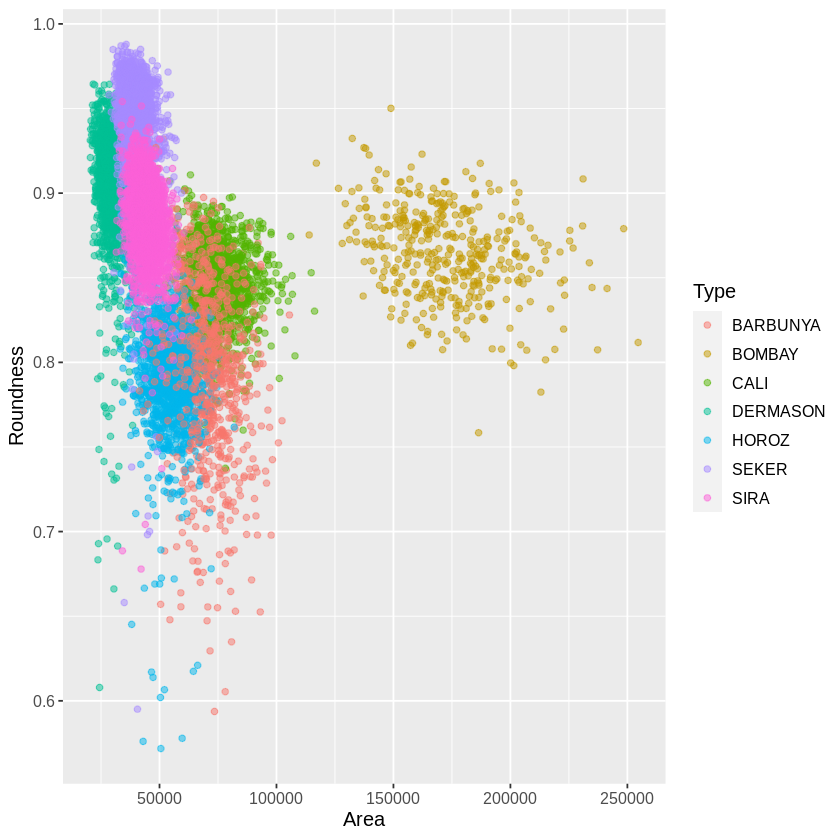

In [5]:
#Graphing the training dataset

area_ecc <- bean_train |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Area", 
       y = "Roundness",
       color = "Type") +
  theme(text = element_text(size = 12))
area_ecc

In [6]:
#Summarize training dataset
bean_class_dist <- bean_train |>
                group_by(Class)|>
                summarize(count = n()) |>
                mutate(percentage_dist = 100*count/nrow(bean_train))
bean_class_dist

Class,count_bean,percentage_dist
<chr>,<int>,<dbl>
BARBUNYA,996,9.758009
BOMBAY,404,3.958068
CALI,1226,12.011365
DERMASON,2656,26.021358
HOROZ,1431,14.019790
SEKER,1521,14.901538
SIRA,1973,19.329872


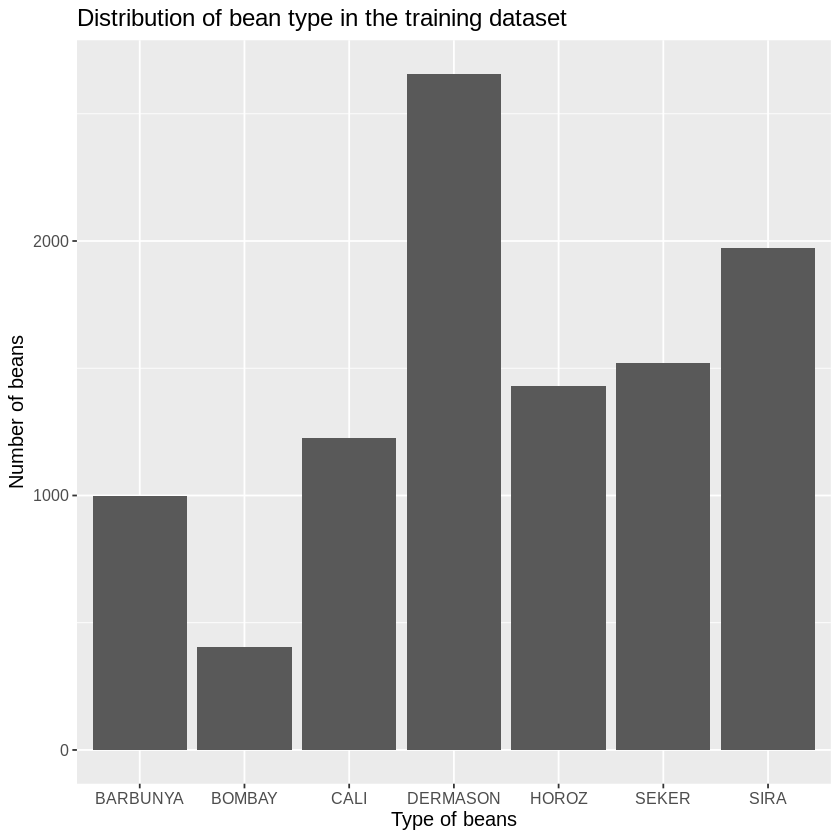

In [7]:
bean_class_dist_plot <- bean_class_dist |>
                        ggplot(aes(x=Class, y = count_bean))+
                        geom_bar(stat = "identity")+
                        labs(x= "Type of beans",
                             y = "Number of beans")+
                        ggtitle("Distribution of bean type in the training dataset")+
                        theme(text = element_text(size = 12))
bean_class_dist_plot

In [7]:
#Statistical Distribution of predictor based on class
features_dist_by_class <- bean_train |>
                group_by(Class)|>
                summarize(max_area = max(Area),
                          min_area = min(Area),
                          max_roundness = max(roundness),
                          min_roundness = min(roundness))
features_dist_by_class

Class,max_area,min_area,max_roundness,min_roundness
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BARBUNYA,105542,41487,0.9319586,0.5937083
BOMBAY,254616,114004,0.9501045,0.7584168
CALI,116272,45504,0.9200291,0.7374636
DERMASON,42147,20420,0.9666028,0.6078674
HOROZ,81929,33263,0.9190136,0.5718009
SEKER,59385,28395,0.9879197,0.5950484
SIRA,63612,31519,0.9541042,0.6778369


In [8]:
#Statistical Distribution in Features of varieties of dry bean

features_dist <- bean_train |>
            pivot_longer(cols= Area:ShapeFactor4,
                         names_to = "Features",
                         values_to = "values") |>
            group_by(Features) |>
            summarize(Mean = mean(values),
                      Min = min(values),
                      Max = max(values),
                     Std_Deviation = sd(values))
features_dist

Features,Mean,Min,Max,Std_Deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Area,5.316321e+04,2.042000e+04,2.546160e+05,2.959663e+04
AspectRation,1.582878e+00,1.036423e+00,2.430306e+00,2.465159e-01
Compactness,7.999492e-01,6.405768e-01,9.816111e-01,6.161852e-02
ConvexArea,5.388229e+04,2.068400e+04,2.632610e+05,3.004866e+04
Eccentricity,7.508417e-01,2.627744e-01,9.114230e-01,9.179368e-02
EquivDiameter,2.532493e+02,1.612438e+02,5.693744e+02,5.962082e+01
Extent,7.502093e-01,5.666693e-01,8.661946e-01,4.908532e-02
MajorAxisLength,3.203253e+02,1.836012e+02,7.388602e+02,8.608262e+01
MinorAxisLength,2.024413e+02,1.225127e+02,4.601985e+02,4.538716e+01


# Methods
1. Data cleaning
- We will load the raw data set into R and cleaning it. 

2. Visualize Data
- Next, we will create visualizations such as scatterplots to identify any trends or potential outliers in the data.

3. Select Variables
- We will then select two variables: roundness and area as they are the most relevant variables for predicting the type of bean based on the physical dimensions (height and weight). 

4. Model the Data
- We will create a k-nearest neighbors (KNN) classification model using roundness and area as predictors. First, we will split the data into a training set and a testing set. Next, we will perform cross-validation by fitting the KNN model with different values of k on the training set. The testing set (has untrained data) will be used to evaluate the generalizability of the model and avoid bias. By using unseen data, we can assess the model's ability to classify new observations accurately. Finally, the testing data will be used to assess the accuracy of the KNN model for each k value, and the k value with the highest accuracy will be chosen as the optimal parameter for the model.racy as the optimal parameter for our model.

5. Visualization
- We'll make a scatterplot with colored data points for each bean type to visualize the model's performance in separating them based on the two predictors. Additionally, we'll create a confusion matrix to display the model's correct and incorrect predictions for each bean type.


# Expected outcomes and significance

What do we expect to find?
- With the help of a classification model, we expect to find a well-performing model that can predict the type of beans based on their roundness and area with high accuracy. On the visualization, we also expect to see a cluster for different types of bean in various colors.  

What impact could such findings have?
- This classification model can impact the food and agriculture industry. An automated system can be created to classifiy the type of bean based on their physical appearance. This is espcially useful when food and agriculture companies collect different types of beans together, dry them, and want to package them based on different types. The model we built can help to streamline the service, gain quality control and reduce the time for people to manually separate the beans. 

What future questions could this lead to?
- Can other variables such as major axis length or the perimeter be good predictors of the type? And are they better predictors than roundness and area?
- Can the classification model be used for different types of crops such as rice? 

In [10]:
features_dist_based_bean_type <- bean_train |>
            pivot_longer(cols= Area:ShapeFactor4,
                         names_to = "Features",
                         values_to = "values") |>
            group_by(Features,Class) |>
            summarize(Mean = mean(values),
                     Std_Deviation = sd(values))
features_dist_based_bean_type

`summarise()` has grouped output by 'Features'. You can override using the
`.groups` argument.


Features,Class,Mean,Std_Deviation
<chr>,<chr>,<dbl>,<dbl>
Area,BARBUNYA,6.958191e+04,1.035772e+04
Area,BOMBAY,1.733037e+05,2.333249e+04
Area,CALI,7.533458e+04,9.478638e+03
Area,DERMASON,3.204878e+04,4.687943e+03
Area,HOROZ,5.363420e+04,7.297006e+03
Area,SEKER,3.988906e+04,4.844331e+03
Area,SIRA,4.481251e+04,4.576330e+03
AspectRation,BARBUNYA,1.545428e+00,1.235646e-01
⋮,⋮,⋮,⋮


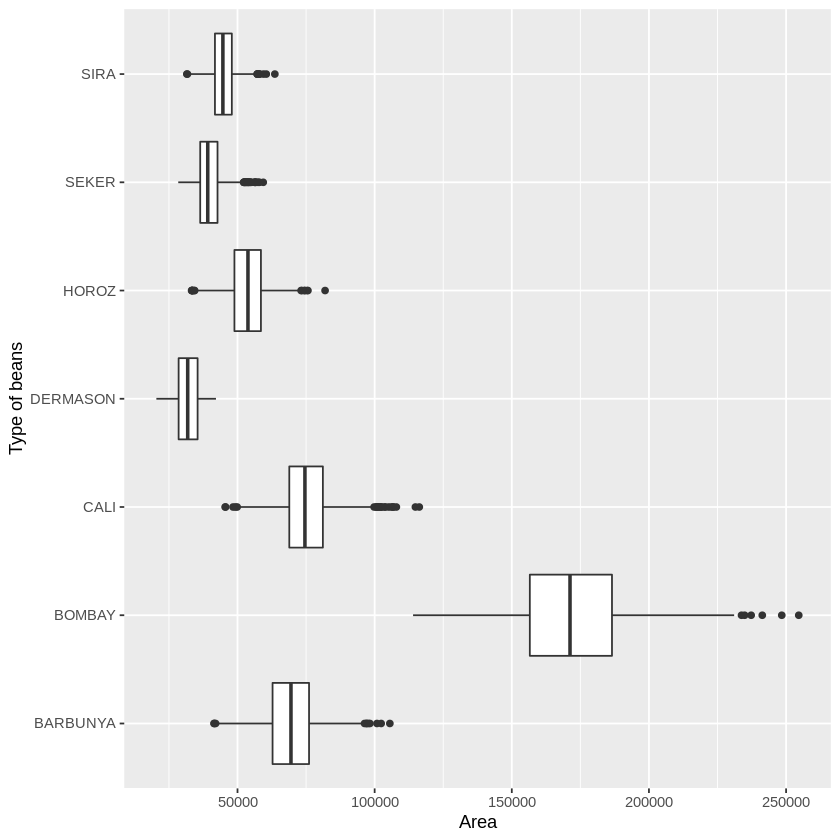

In [43]:
#Graphing 
area_box_plot <- bean_train |>
                ggplot(aes(x = Class, y = Area))+
                geom_boxplot()+
                xlab("Type of beans")+
                ylab("Area")+
                coord_flip()
area_box_plot

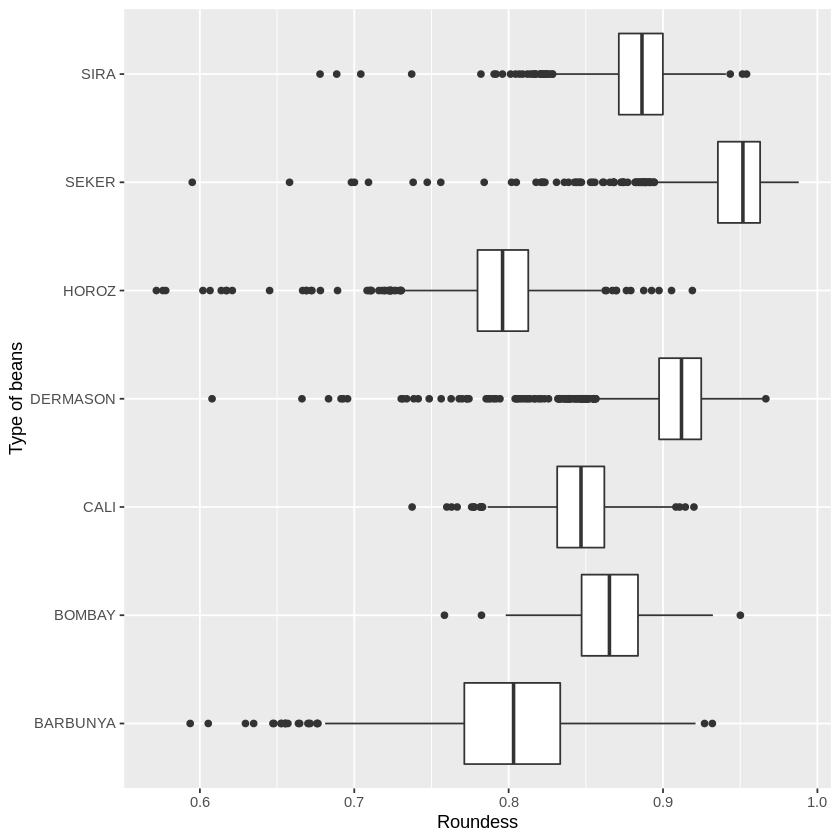

In [42]:
roundness_box_plot <- bean_train |>
                ggplot(aes(x = Class, y = roundness))+
                geom_boxplot()+
                xlab("Type of beans")+
                ylab("Roundess")+
                coord_flip()
roundness_box_plot